In [1]:
!pip install torch-explain

In [1]:
import torch
import torch_explain as te
from torch_explain import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from torch_explain.nn.concepts import ConceptReasoningLayer
import torch.nn.functional as F
import numpy as np

In [28]:
x, c, y = datasets.xor(3000)
x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(x, c, y, test_size=0.33, random_state=42)

### Transformation necessary for DCR
y_train = F.one_hot(y_train.long().ravel()).float()
y_test = F.one_hot(y_test.long().ravel()).float()

In [86]:
print(c_train[0])
print(y_train[0])

tensor([1., 0.])
tensor([0., 1.])


You define a **task predictor** (the part of the network that is responsible of the transformation `concepts -> predictions`, in our case the **DCR**) and a concept encoder using a **concept embedding layer** (that goes `inputs -> concepts`)

In [29]:
embedding_size = 8 # Each concept will be made of 8 embeddings
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(in_features=x.shape[1], out_features=10),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(in_features=10, n_concepts=c.shape[1], emb_size=embedding_size),
)

In [30]:
task_predictor = ConceptReasoningLayer(embedding_size, y_train.shape[1])
model = torch.nn.Sequential(concept_encoder, task_predictor)

### **TRAINING**

In [31]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_form = torch.nn.BCELoss()
n_epochs = 501
model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()

    # generate concept and task predictions
    c_emb, c_pred = concept_encoder(x_train)
    y_pred = task_predictor(c_emb, c_pred)

    # compute loss
    concept_loss = loss_form(c_pred, c_train)
    task_loss = loss_form(y_pred, y_train)
    loss = concept_loss + 0.5*task_loss

    loss.backward()
    optimizer.step()

### **EVALUATION**

After training the model, we can evaluate its performance on the test set

In [32]:
c_emb, c_pred = concept_encoder.forward(x_test)
y_pred = task_predictor(c_emb, c_pred)

concept_accuracy = accuracy_score(c_test, c_pred > 0.5)
task_accuracy = accuracy_score(y_test, y_pred > 0.5)

print(f'CONCEPT ACCURACY: {concept_accuracy:.2f}')
print(f'TASK ACCURACY: {task_accuracy:.2f}')

CONCEPT ACCURACY: 1.00
TASK ACCURACY: 1.00


In [33]:
local_explanations = task_predictor.explain(c_emb, c_pred, 'local')
local_explanations[0]

{'sample-id': 0,
 'class': 'y_0',
 'explanation': '~c_0 & ~c_1',
 'attention': [-1.0, -1.0]}

In [34]:
task_predictor.explain(c_emb, c_pred, 'global')

[{'class': 'y_0', 'explanation': '~c_0 & ~c_1', 'count': 244},
 {'class': 'y_0', 'explanation': 'c_0 & c_1', 'count': 248},
 {'class': 'y_1', 'explanation': '~c_0 & c_1', 'count': 244},
 {'class': 'y_1', 'explanation': 'c_0 & ~c_1', 'count': 254}]

In [35]:
task_predictor.explain(c_emb, c_pred, 'exact')[0]

{'sample-id': 0,
 'class': 'y_0',
 'explanation': '1.000 (~c_0) & 1.000 (~c_1)',
 'attention': [-1.0, -1.0]}

## **My test for training a Decision Tree**

In [36]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

Creating the dataset. For each sample I get the sign terms and feature attn

In [37]:
# I HAVE TO GET EVERYTHING FROM THE TRAINING SET
c_emb, c_pred = concept_encoder.forward(x_train)
y_pred_dt, sign_attn_dt, filter_attn_dt = task_predictor.forward(c_emb, c_pred, return_attn=True)

# To get the sign terms (FUTURE WORK IMPEMENT A BOOL ABLE TO TELL ME TO RETURN DIRECTLY SIGN TERMS AND WHAT I NEED)
from torch_explain.nn.semantics import GodelTNorm

logic = GodelTNorm()
values = c_pred.unsqueeze(-1).repeat(1, 1, len(y_pred_dt[1]))
sign_terms_dt = logic.iff_pair(sign_attn_dt, values)
sign_terms_dt = sign_terms_dt.detach().numpy()
y_pred_dt = y_pred_dt.detach().numpy()
sign_attn_dt = sign_attn_dt.detach().numpy()
filter_attn_dt = filter_attn_dt.detach().numpy()

In [62]:
def print_value(value, name):
    print(f'{name}: {value}')
    print(f'SHAPE: {value.shape}')
    print()

c_emb, c_pred = concept_encoder.forward(x_train)
y_pred_dt, sign_attn_dt, filter_attn_dt = task_predictor.forward(c_emb, c_pred, return_attn=True)
logic = GodelTNorm()
print_value(sign_attn_dt[0], 'sign_attn')
print_value(filter_attn_dt[0], 'filter_attn')
values = c_pred.unsqueeze(-1).repeat(1, 1, len(y_pred_dt[1]))
print_value(values[0], 'value')
sign_terms_dt = logic.iff_pair(sign_attn_dt, values)
print_value(sign_terms_dt[0], 'sign_terms')
filtered_values = logic.disj_pair(sign_terms_dt, logic.neg(filter_attn_dt))
print_value(filtered_values[0], 'filtered_value')

sign_attn: tensor([[9.5295e-01, 9.9979e-01],
        [1.0000e+00, 4.0910e-07]], grad_fn=<SelectBackward0>)
SHAPE: torch.Size([2, 2])

filter_attn: tensor([[1., 1.],
        [1., 1.]], grad_fn=<SelectBackward0>)
SHAPE: torch.Size([2, 2])

value: tensor([[1.0000e+00, 1.0000e+00],
        [2.4110e-05, 2.4110e-05]], grad_fn=<SelectBackward0>)
SHAPE: torch.Size([2, 2])

sign_terms: tensor([[9.5295e-01, 9.9979e-01],
        [2.4110e-05, 9.9998e-01]], grad_fn=<SelectBackward0>)
SHAPE: torch.Size([2, 2])

filtered_value: tensor([[9.5295e-01, 9.9979e-01],
        [2.4110e-05, 9.9998e-01]], grad_fn=<SelectBackward0>)
SHAPE: torch.Size([2, 2])



In [11]:
print(f'y_pred_dt: {y_pred_dt.shape}')
print(f'sign_terms_dt: {sign_terms_dt.shape}')
print(f'filter_attn_dt: {filter_attn_dt.shape}')
# y_pred = (n_samples, n_classes)
# sign_terms_dt = (n_samples, n_concepts, n_classes)

y_pred_dt: (335, 2)
sign_terms_dt: (335, 2, 2)
filter_attn_dt: (335, 2, 2)


In [12]:
print(f'sign_terms_dt: {sign_terms_dt[:2]}')
print(f'filter_attn_dt: {filter_attn_dt[:2]}')

sign_terms_dt: [[[1.0000000e+00 2.6643914e-07]
  [1.0000000e+00 7.5483863e-04]]

 [[1.0000000e+00 1.3239163e-06]
  [1.0000000e+00 1.5816221e-10]]]
filter_attn_dt: [[[1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]]]


In [65]:
sign_terms_dt[:,0,:].shape

torch.Size([2010, 2])

In [87]:
for i,sign in enumerate(filter_attn_dt[:,0,:]):
    if i<3:
        print(sign)
        print("Dopo SQUEEZE")
        print(sign.squeeze())
        print()

# for i,sign in enumerate(sign_terms_dt):
#     if i<3:
#         print(sign)

tensor([1., 1.], grad_fn=<UnbindBackward0>)
Dopo SQUEEZE
tensor([1., 1.], grad_fn=<SqueezeBackward0>)

tensor([1., 1.], grad_fn=<UnbindBackward0>)
Dopo SQUEEZE
tensor([1., 1.], grad_fn=<SqueezeBackward0>)

tensor([1., 1.], grad_fn=<UnbindBackward0>)
Dopo SQUEEZE
tensor([1., 1.], grad_fn=<SqueezeBackward0>)



In [72]:
np.vstack([sign.detach().numpy() for sign in sign_terms_dt[:,0,:]])

array([[9.5295107e-01, 9.9979383e-01],
       [3.7253421e-06, 9.9999624e-01],
       [9.9999928e-01, 7.1525574e-07],
       ...,
       [1.0000000e+00, 2.2609441e-03],
       [1.4770031e-04, 1.0000000e+00],
       [1.0000000e+00, 3.4327233e-20]], dtype=float32)

In [38]:
# sign_terms_dt[:2, 0, :] ---> Concept_0
sign_concept_0 = np.vstack([sign.squeeze() for sign in sign_terms_dt[:,0,:]])
sign_concept_1 = np.vstack([sign.squeeze() for sign in sign_terms_dt[:,1,:]])
filter_concept_0 = np.vstack([f.squeeze() for f in filter_attn_dt[:,0,:]])
filter_concept_1 = np.vstack([f.squeeze() for f in filter_attn_dt[:,1,:]])

final_features = np.hstack((sign_concept_0, sign_concept_1, filter_concept_0, filter_concept_1))
names = ['sign_c0_y0', 'sign_c0_y1', 'sign_c1_y0', 'sign_c1_y1', 'filter_c0_y0', 'filter_c0_y1', 'filter_c1_y0', 'filter_c1_y1']

In [14]:
sign_concept_0[:2]

array([[1.0000000e+00, 2.6643914e-07],
       [1.0000000e+00, 1.3239163e-06]], dtype=float32)

In [15]:
sign_concept_1[:2]

array([[1.0000000e+00, 7.5483863e-04],
       [1.0000000e+00, 1.5816221e-10]], dtype=float32)

In [16]:
np.hstack((sign_concept_0[:2], sign_concept_1[:2])) #sign_c0_y0, sign_c0_y1, sign_c1_y0, sign_c1_y1

array([[1.0000000e+00, 2.6643914e-07, 1.0000000e+00, 7.5483863e-04],
       [1.0000000e+00, 1.3239163e-06, 1.0000000e+00, 1.5816221e-10]],
      dtype=float32)

In [39]:
import pandas as pd
df = pd.DataFrame(final_features, columns=names)

# Stampa il DataFrame
print(df.head())

   sign_c0_y0    sign_c0_y1  sign_c1_y0  sign_c1_y1  filter_c0_y0  \
0    0.952951  9.997938e-01    0.000024    0.999976           1.0   
1    0.000004  9.999962e-01    0.830642    1.000000           1.0   
2    0.999999  7.152557e-07    0.999670    1.000000           1.0   
3    0.000005  1.000000e+00    0.000029    1.000000           1.0   
4    0.999988  1.955032e-05    0.999993    0.013874           1.0   

   filter_c0_y1  filter_c1_y0  filter_c1_y1  
0           1.0           1.0           1.0  
1           1.0           1.0           1.0  
2           1.0           1.0           1.0  
3           1.0           1.0           1.0  
4           1.0           1.0           1.0  


In [19]:
print(df.describe())

         sign_c0_y0    sign_c0_y1    sign_c1_y0    sign_c1_y1  filter_c0_y0  \
count  3.350000e+02  3.350000e+02  3.350000e+02  3.350000e+02         335.0   
mean   6.331378e-01  6.478750e-01  6.074291e-01  5.617099e-01           1.0   
std    4.619841e-01  4.498585e-01  4.736344e-01  4.806524e-01           0.0   
min    2.329828e-12  4.412448e-09  3.284327e-18  2.030540e-22           1.0   
25%    1.784742e-03  1.961361e-02  2.195085e-04  8.026807e-06           1.0   
50%    9.984363e-01  9.976493e-01  9.994098e-01  9.660276e-01           1.0   
75%    1.000000e+00  9.999999e-01  1.000000e+00  9.999996e-01           1.0   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00           1.0   

       filter_c0_y1  filter_c1_y0  filter_c1_y1  
count         335.0         335.0         335.0  
mean            1.0           1.0           1.0  
std             0.0           0.0           0.0  
min             1.0           1.0           1.0  
25%             1.0           1.0     

In [40]:
tuples = y_pred_dt>0.5
y_dt = ['Class_0' if t[0] else 'Class_1' for t in tuples]
dt.fit(df, y_dt)

DecisionTreeClassifier()

In [91]:
gg = [f"Class_{np.argmax(sample)}" for sample in y_pred_dt>0.5]
gg == y_dt

True

In [ ]:
dt.predict()

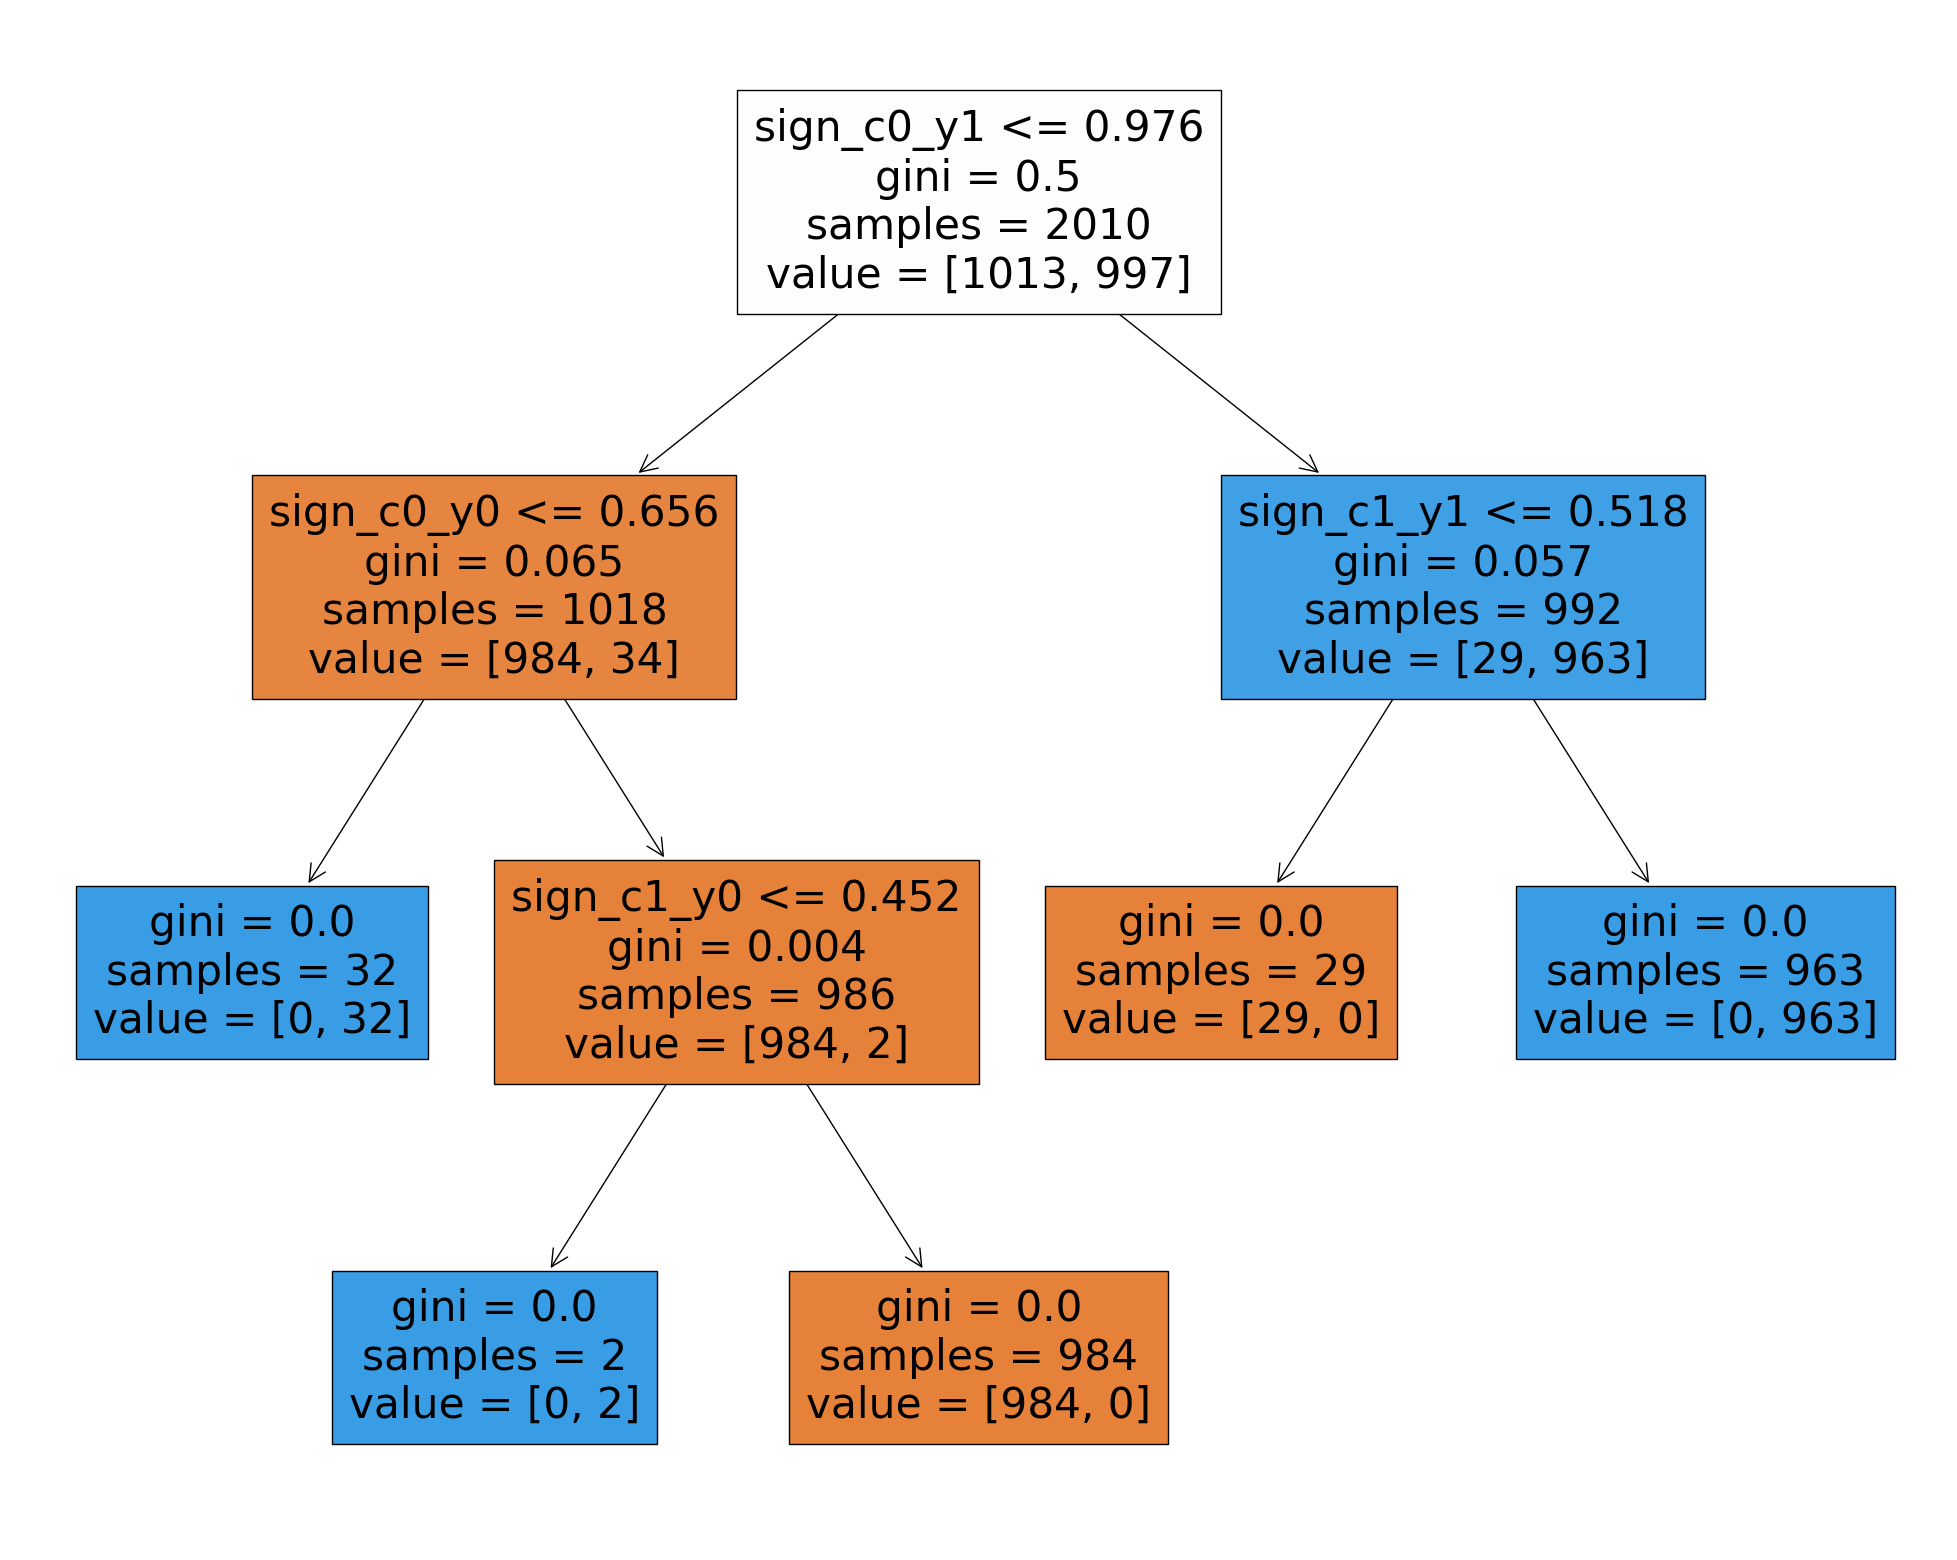

In [41]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt, feature_names=df.columns, filled=True)

Provo a fare un albero per ogni classe?


In [43]:
# Crea un DataFrame con solo le colonne y0
df_y0 = df.filter(like='y0')

# Crea un DataFrame con solo le colonne y1
df_y1 = df.filter(like='y1')

In [81]:
y_dt0 = [True if t[0] else False for t in tuples]
y_dt1 = [True if t[1] else False for t in tuples]

clf0 = DecisionTreeClassifier(max_depth=2)
clf0.fit(df_y0, y_dt0)

clf1 = DecisionTreeClassifier()
clf1.fit(df_y1, y_dt1)

# Pruning 

DecisionTreeClassifier()

In [92]:
y_dt0[:5]

[False, False, True, False, True]

In [94]:
[f'Class_{0}' if np.argmax(pred) == 0 and pred[np.argmax(pred)] > 0.5 else 'Other' for pred in y_pred_dt>0.5][:5]

['Other', 'Other', 'Class_0', 'Other', 'Class_0']

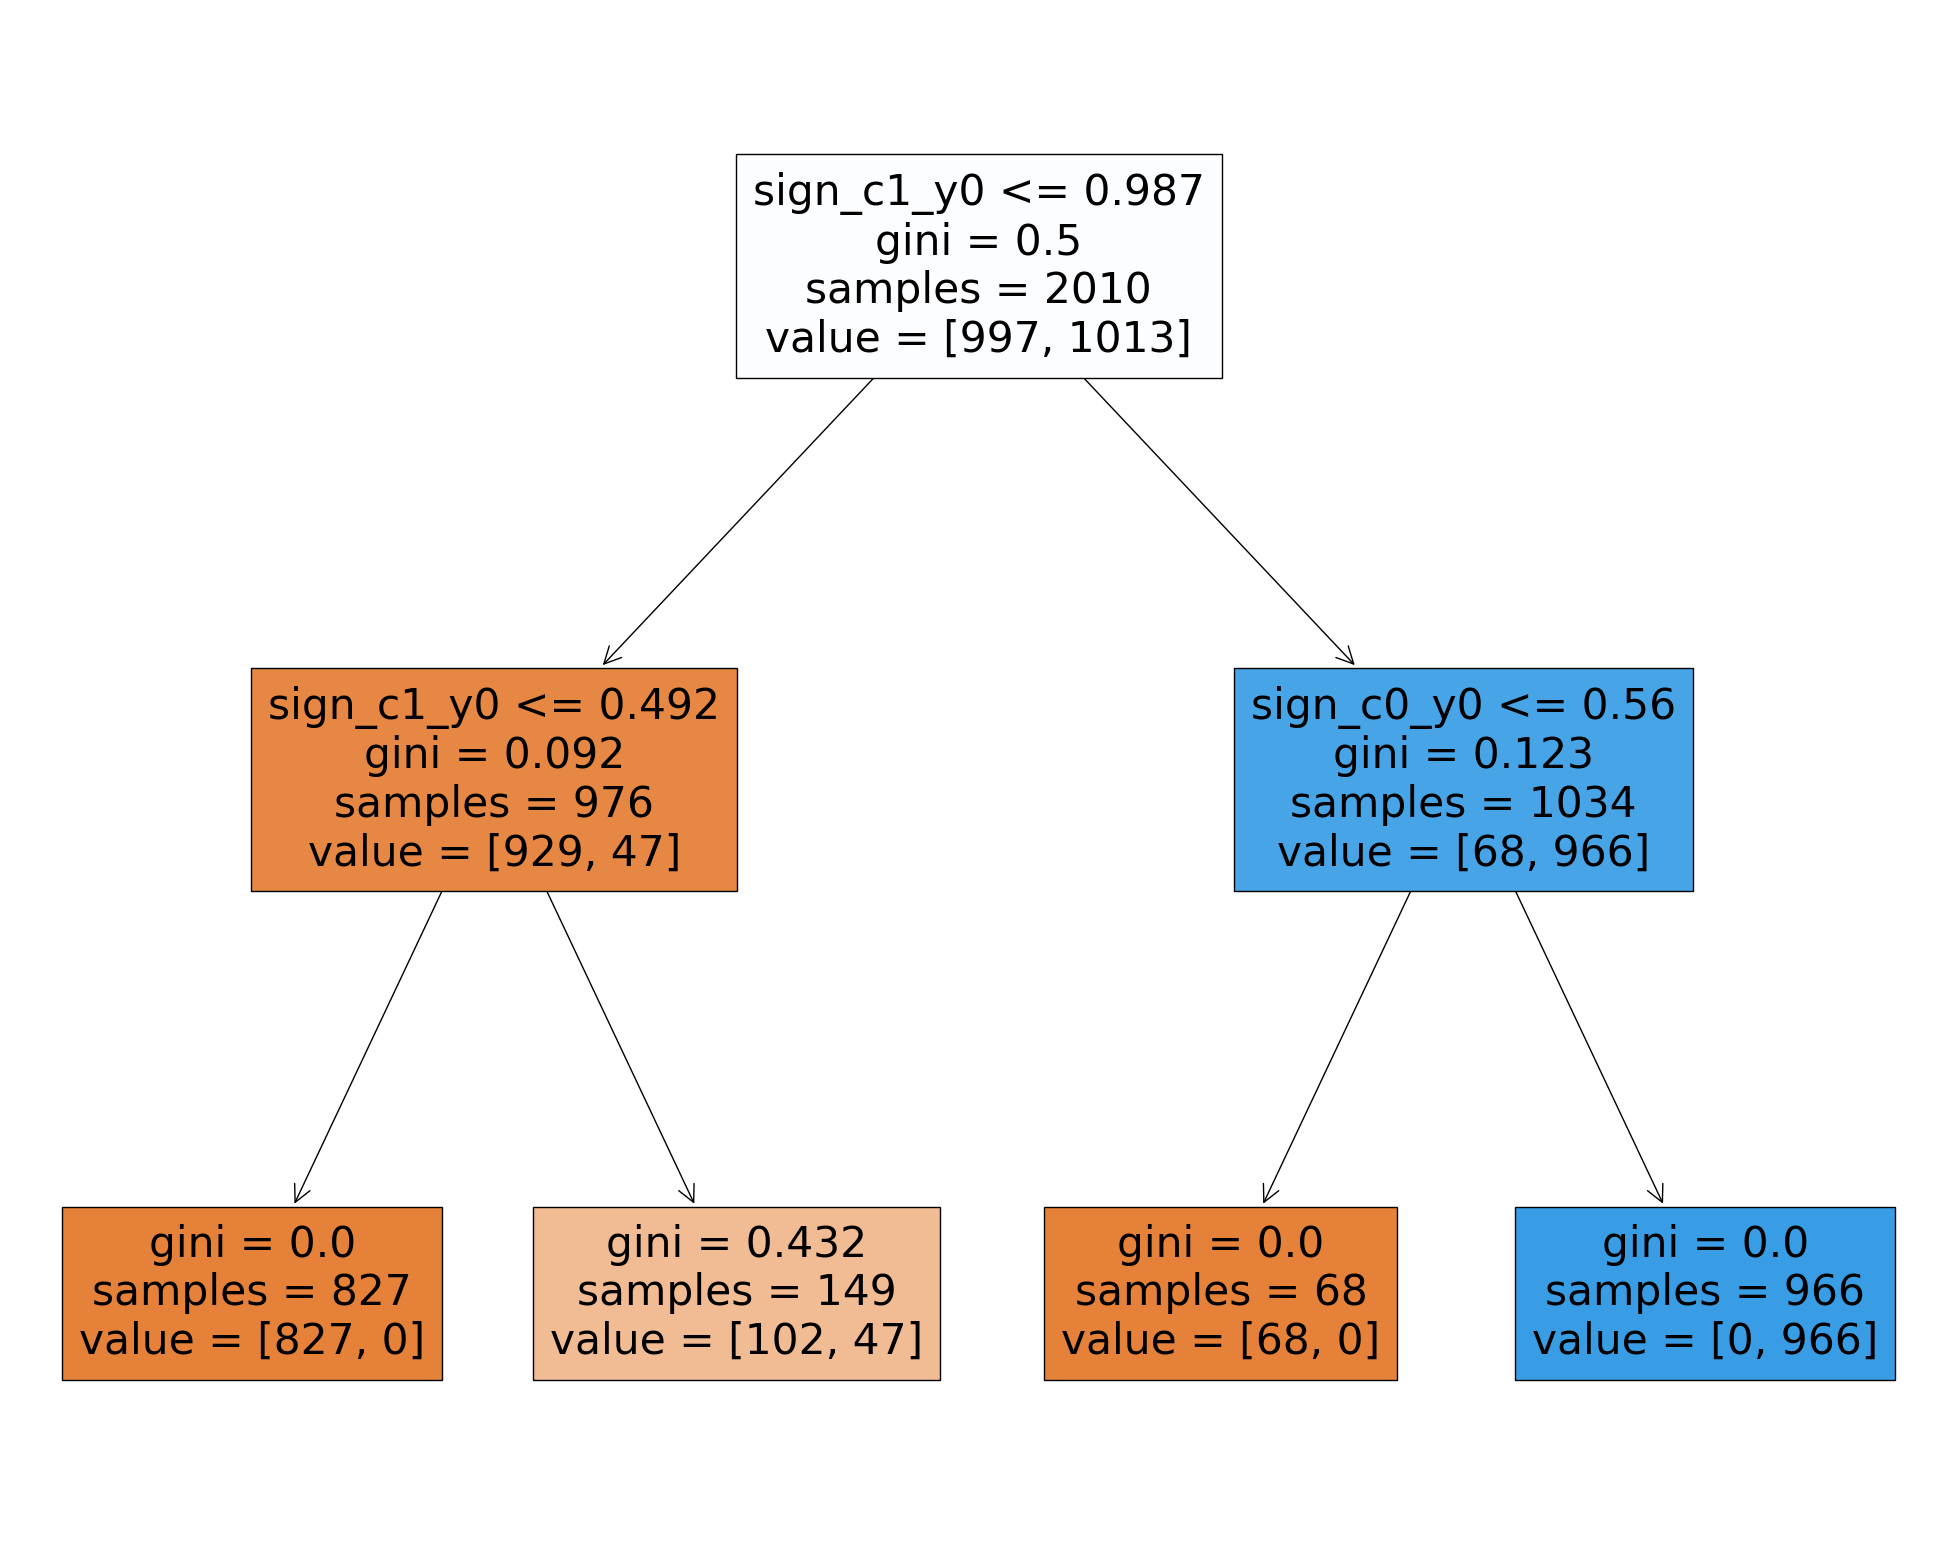

In [82]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf0, feature_names=df_y0.columns, filled=True)
# Cambiare gini index?
# Dipende dal dataset

In [80]:
clf0.predict(np.array([[0.2,0.,1.,1.]]))

c:\Users\robit\.conda\envs\explandtrustAI\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([False])

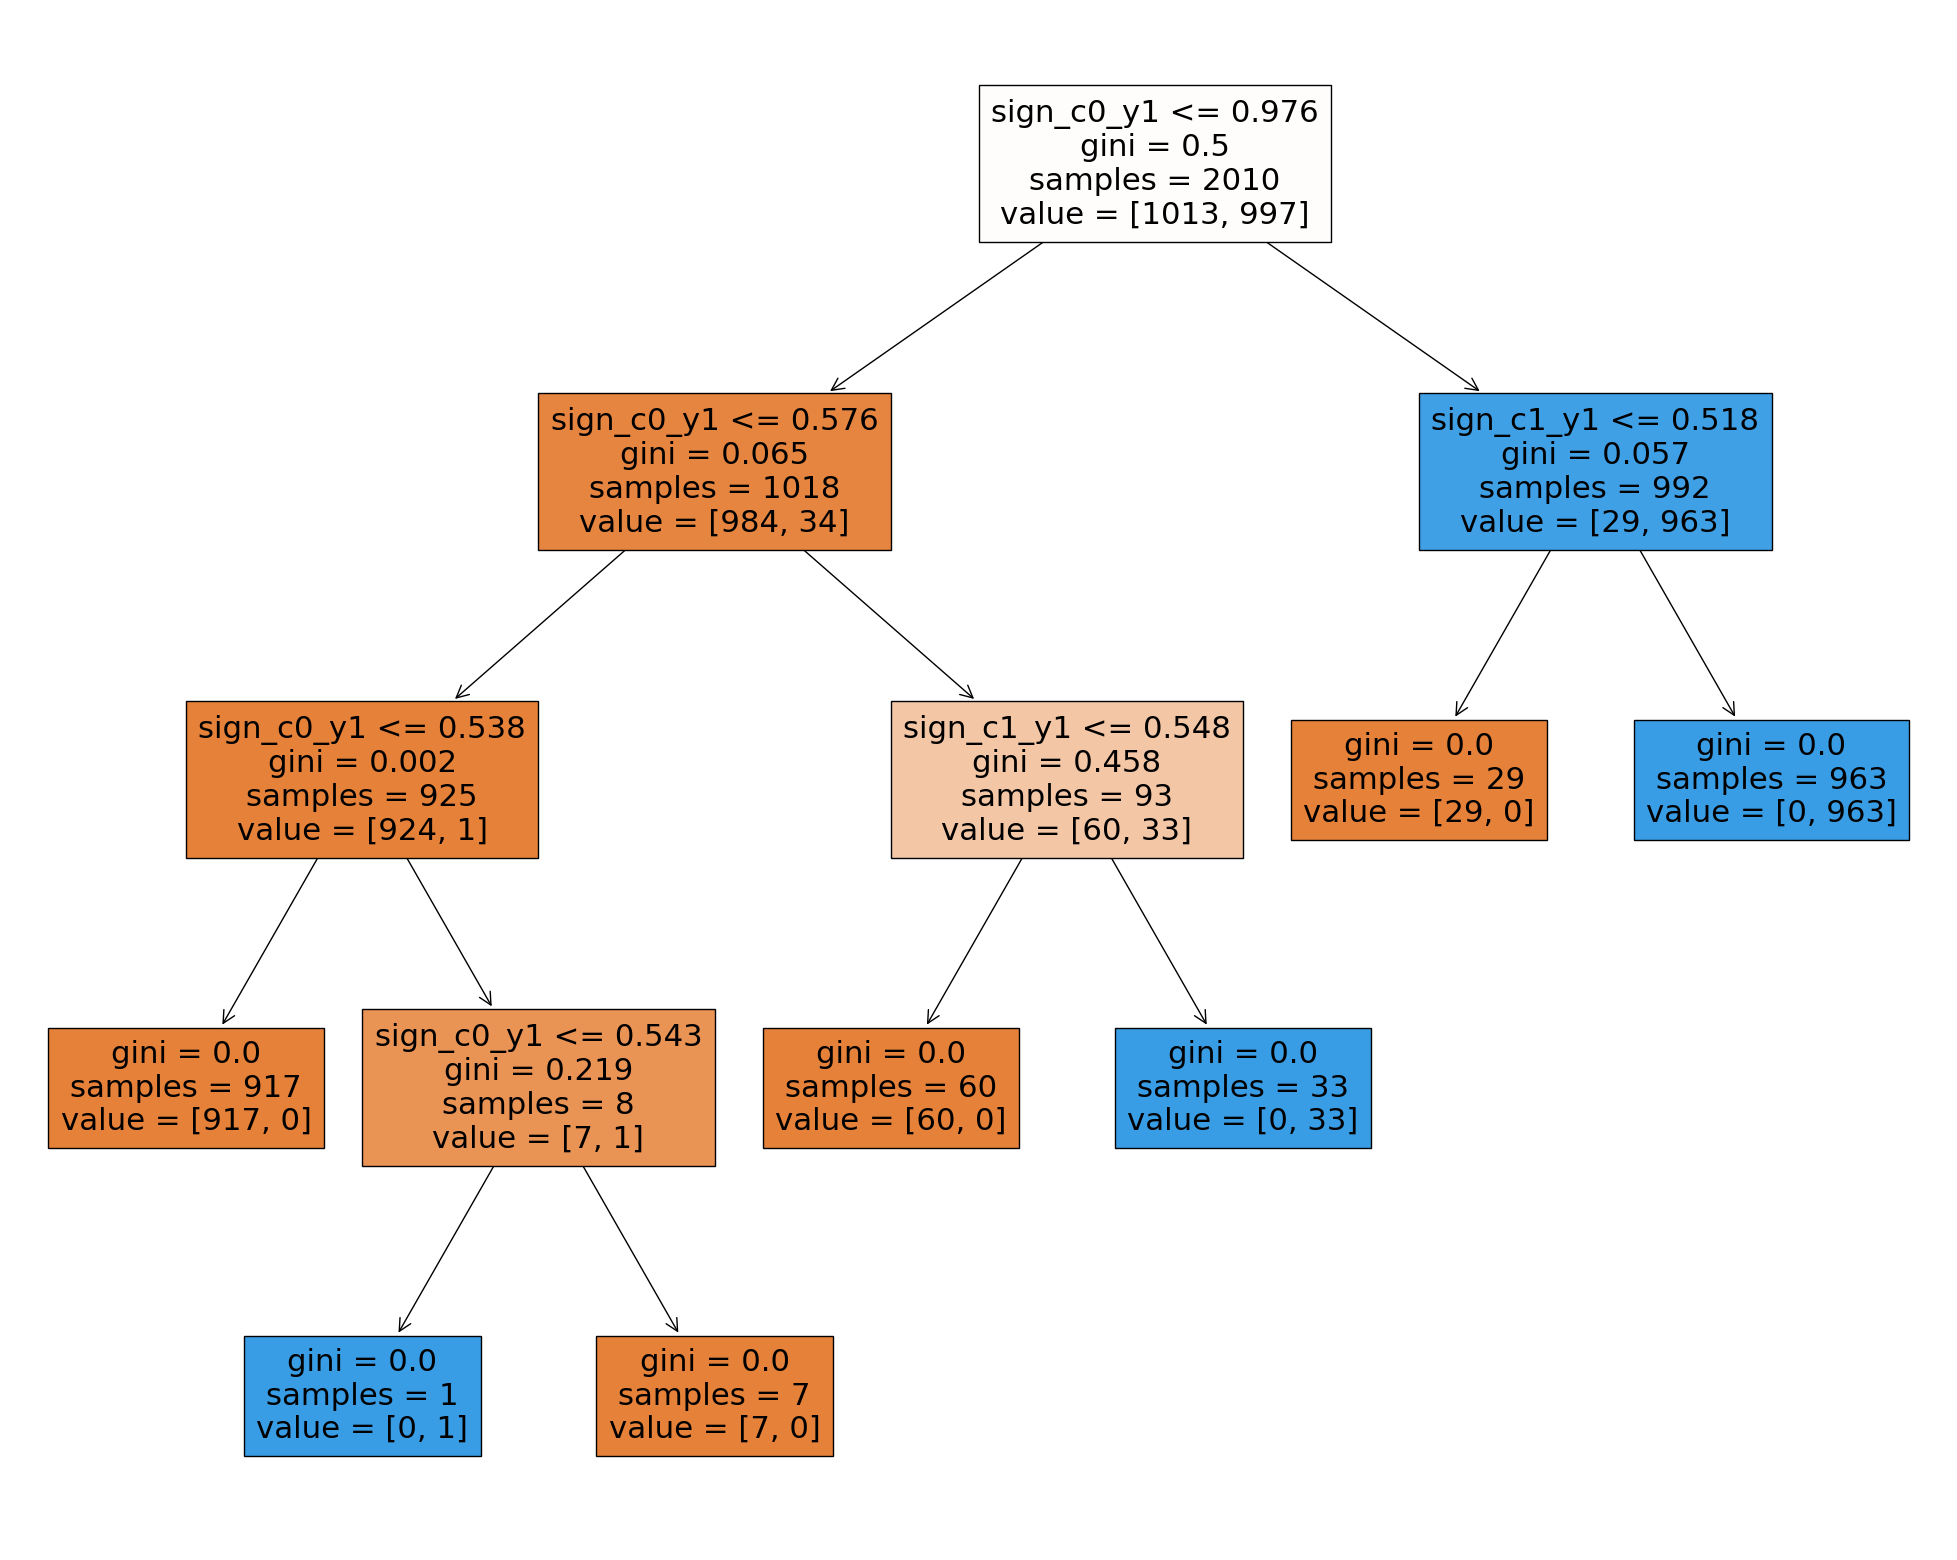

In [46]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf1, feature_names=df_y1.columns, filled=True)

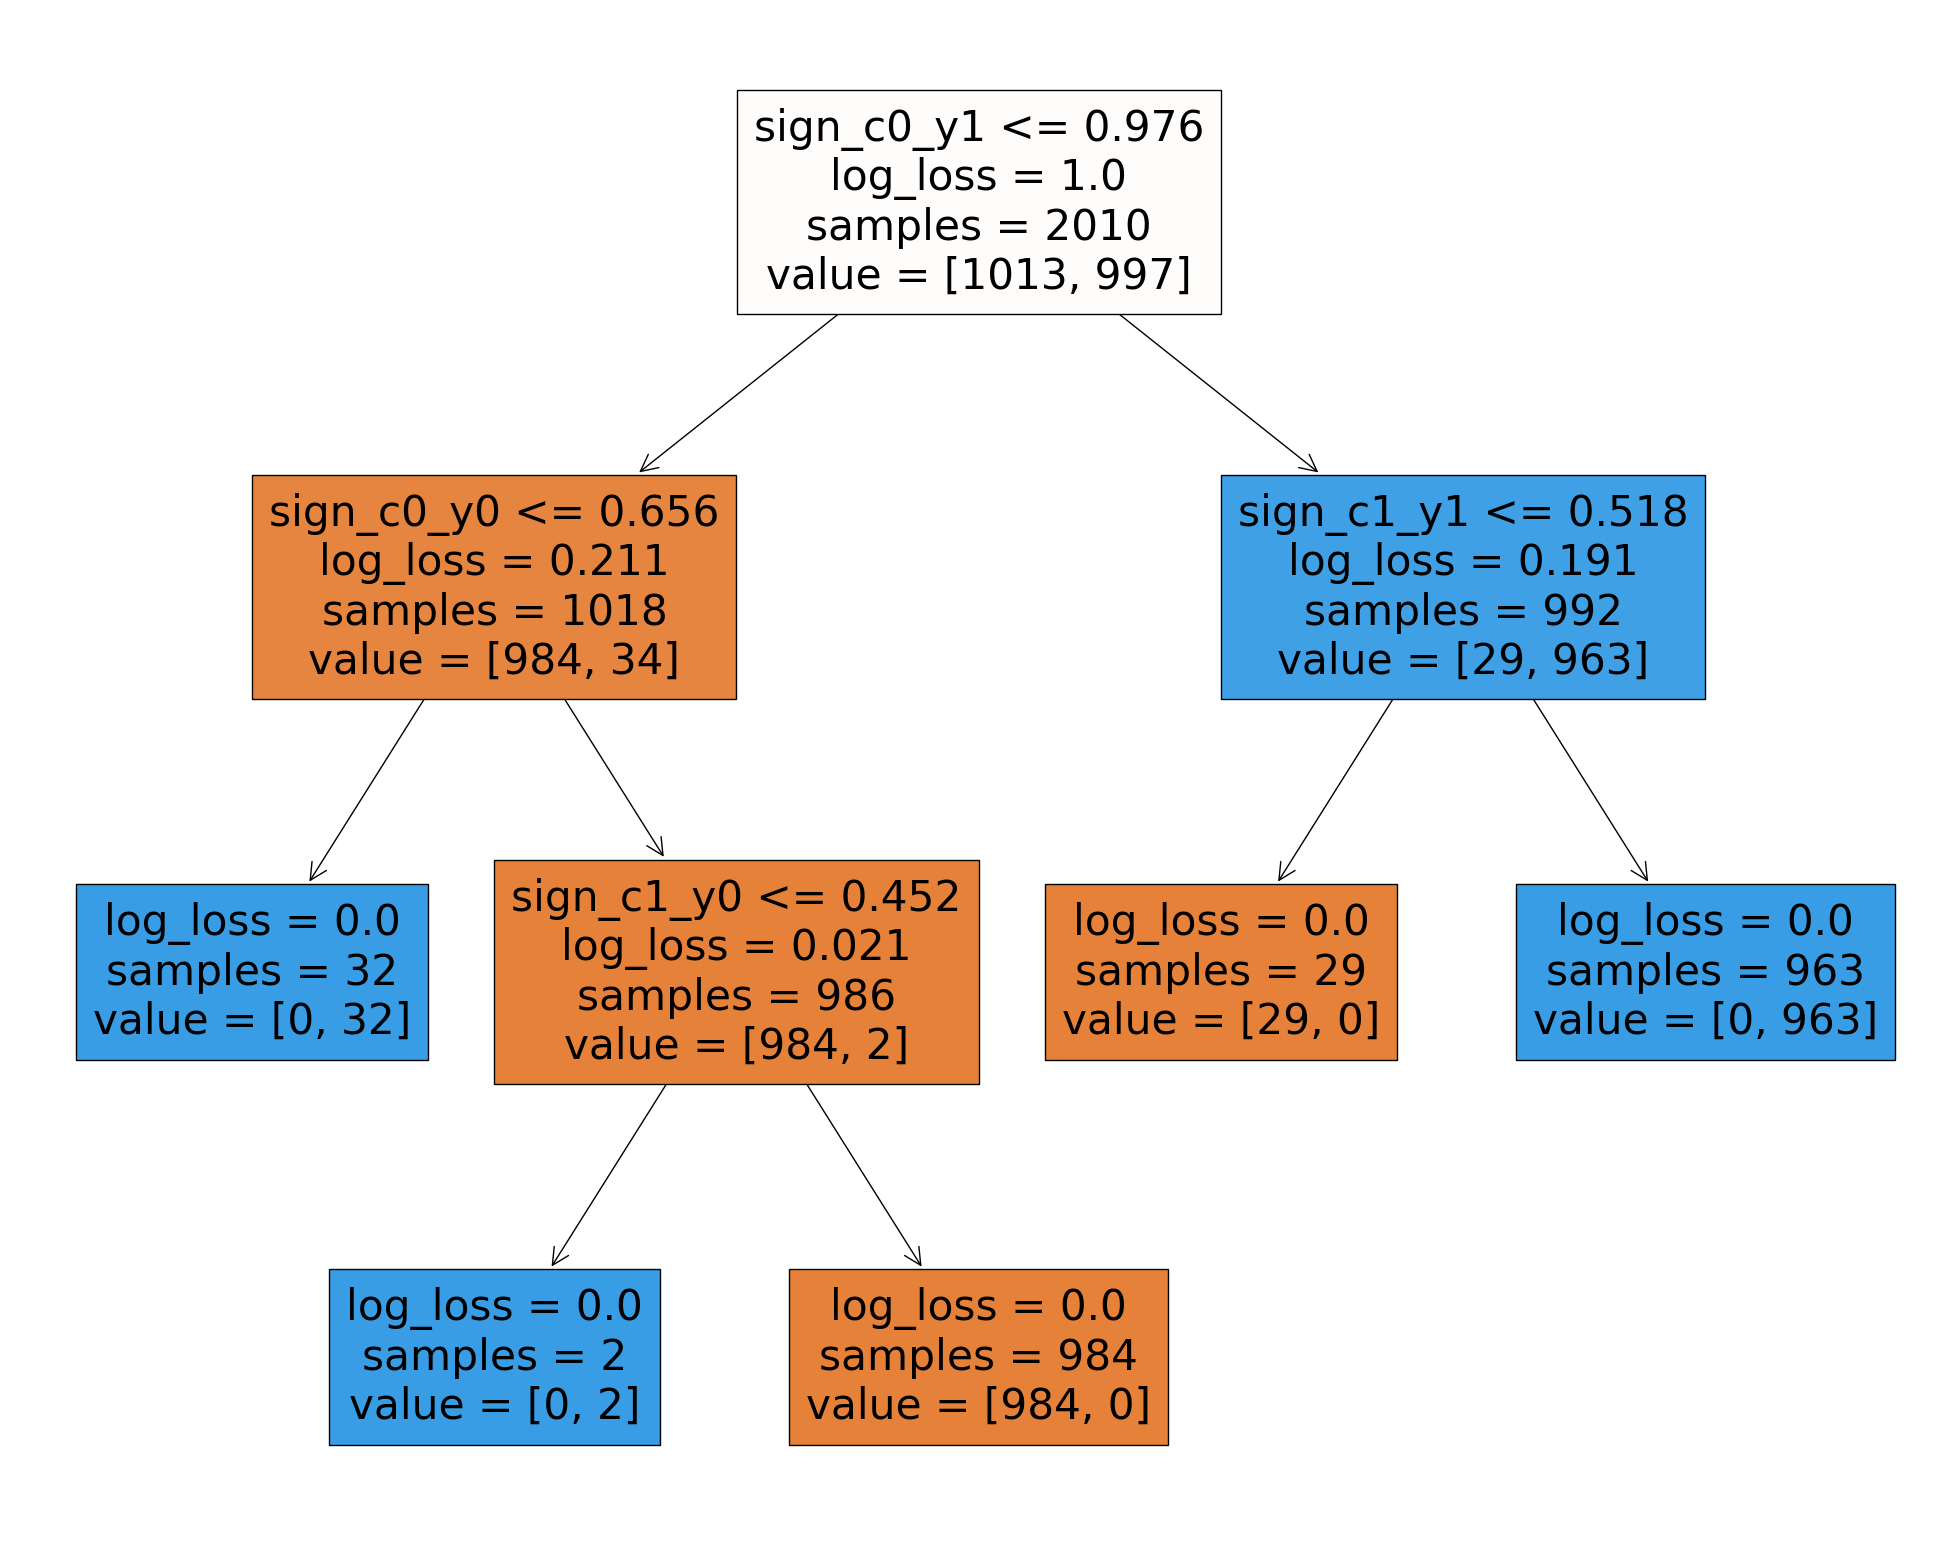

In [74]:
## Provo con un altro criterion
clf_entr = DecisionTreeClassifier(criterion="log_loss")
clf_entr.fit(df, y_dt)
fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf_entr, feature_names=df.columns, filled=True)

In [20]:
# PROVIAMO SE FUNZIONA
# Gli infilo il test set, facendo le opportune trasformazioni e vedo se l'accuracy rimane
c_emb, c_pred = concept_encoder.forward(x_test)
y_pred_dt, sign_attn_dt, filter_attn_dt = task_predictor.forward(c_emb, c_pred, return_attn=True)

# To get the sign terms (FUTURE WORK IMPEMENT A BOOL ABLE TO TELL ME TO RETURN DIRECTLY SIGN TERMS AND WHAT I NEED)
from torch_explain.nn.semantics import GodelTNorm

logic = GodelTNorm()
values = c_pred.unsqueeze(-1).repeat(1, 1, len(y_pred_dt[1]))
sign_terms_dt = logic.iff_pair(sign_attn_dt, values)
sign_terms_dt = sign_terms_dt.detach().numpy()
y_pred_dt = y_pred_dt.detach().numpy()
sign_attn_dt = sign_attn_dt.detach().numpy()
filter_attn_dt = filter_attn_dt.detach().numpy()

In [21]:
sign_concept_0 = np.vstack([sign.squeeze() for sign in sign_terms_dt[:,0,:]])
sign_concept_1 = np.vstack([sign.squeeze() for sign in sign_terms_dt[:,1,:]])
filter_concept_0 = np.vstack([f.squeeze() for f in filter_attn_dt[:,0,:]])
filter_concept_1 = np.vstack([f.squeeze() for f in filter_attn_dt[:,1,:]])

final_features = np.hstack((sign_concept_0, sign_concept_1, filter_concept_0, filter_concept_1))
names = ['sign_c0_y0', 'sign_c0_y1', 'sign_c1_y0', 'sign_c1_y1', 'filter_c0_y0', 'filter_c0_y1', 'filter_c1_y0', 'filter_c1_y1']
df = pd.DataFrame(final_features, columns=names)

In [22]:
y_dt = ['Class_0' if t[0] else 'Class_1' for t in y_test]
y_predicted = dt.predict(df)
accuracy_score(y_dt, y_predicted)

0.9878787878787879

In [23]:
# Y_mask = np.argmax(y_pred_dt, axis=1)
# sign_features_per_concept = np.vstack([sign[:,Y_mask[i]].squeeze() for i,sign in enumerate(sign_attn_dt)])
# sign_features_per_concept.shape
# relevance_features_per_concept = np.vstack([r[:,Y_mask[i]].squeeze() for i,r in enumerate(filter_attn_dt)])
# relevance_features_per_concept.shape
# dataset = np.hstack((sign_features_per_concept, relevance_features_per_concept))
# dataset.shape
# dt.fit(dataset, Y_mask)